# JobSeekerAgency: an Agentic Workflow to make the whole process of find your next dream job effortless

In [1]:
import sys
sys.path.append('../python')
sys.path.append('../../keys')

In [35]:
%load_ext autoreload
%autoreload 2

import os

## Custom scripts:
import Constants as C
from nodes_edges import *
from tools import *

## langchain:
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.tools import tool

## LLMs from providers:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

## Langgraph:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

## Typing
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = C.ANTHROPIC_API_KEY

In [52]:
tools  = [get_NOVARTIS_jobs,get_AWS_jobs,get_YPSOMED_jobs]
tools_by_name = {tool.name: tool for tool in tools}

In [53]:
class ChatMessages(TypedDict):
    
    messages: List[BaseMessage] # the BaseMessages for agents
    company: str
    question: HumanMessage # store the original question
    codescript: str # the script written by code-writer agent
    codeiter: int # keeps track of many times code has been modified
    joblist: str # the job list results from parsing career page
    # mytools: List[{}] # the list of tools to access the company jobs # !! YOU CANNOT PASS TOOLS HERE, OTHERWISE ERROR!!
    company2careerpage: dict # associates the company with their jobs postings

pass
## Nodes / Agents
## --------------------------------------------------

def call_agent(state):
    """
    First pass to know what to do, if it cannot find a tool to extract job list, then refer to code-writing agent
    """

    print(f'\n>> First pass >>\n')
    
    if "messages" not in state or state["messages"] is None:
        # print('!!! INITIALIZING MESSAGES STATE !!!')
        state["messages"] = []
        state["messages"].append(state["question"])

    system_message = SystemMessage(
        content="""if you get the job list, can you simply output it without any further comments? If not please return 'No'
        """
    )
    state["messages"].append(system_message)
    
    ## preping the agent with tools    
    prompt   = ChatPromptTemplate.from_messages(state['messages']).format()
    # model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)
    model    = ChatAnthropic(model="claude-sonnet-4-5",temperature=0).bind_tools(tools)
    response = model.invoke(prompt) # you are calling the llm here!
    print(response.tool_calls)
    state['messages'].append(response)
    print(state['messages'][-1].content)
    return state

def joblist_formatting(state):
    """
    Simply takes the list of job list string and formats to json
    """

    print(f'\n>> Formatting job list >>\n')
    
    messages = state['messages']
    # state["messages"].append(system_message)
    state['joblist'] = messages[-1].content

    # define the format of the final joblist
    class JobList(BaseModel):
        name: str = Field(description='Name of the job')
        url: list = Field(description='The url of the job')
    
    parser       = PydanticOutputParser(pydantic_object=JobList)
    
    human_prompt = HumanMessagePromptTemplate.from_template("{request}\n{format_instructions}")
    chat_prompt  = ChatPromptTemplate.from_messages([human_prompt])
    request      = chat_prompt.format_prompt(request=f"can you split this list {state['joblist']}, which contains job name and url into a nice json format?",
                                         format_instructions=parser.get_format_instructions()).to_messages()
    # model        = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0)
    model        = ChatAnthropic(model='claude-sonnet-4-5',temperature=0)
    response     = model.invoke(request)

    state['messages'].append(response)
    
    return state
    
pass
def code_writing(state):
    """
    Agent writing the code to retrieve jobs for companies
    """
    
    print(f'\n>> Code Writing, iteration {state['codeiter']}>>\n')

    # define the system message
    system_message = SystemMessage(
        content="""You are an expert programmer that is ready to help write some clean and concise python code. Please ensure that:

        1. you use beautiful soup and async_playwright
        2. you should only output python code
        """
    ) # 3. the ouptut of the code should be a list of job names followed by their application url
    # 3. you end with with 'await main()' instead of 'asyncio.run(main())
    sel_               = state['company']
    company2careerpage = state['company2careerpage']
    question   = f"""can you write a short python code to list the jobs from the company {sel_} career page ({company2careerpage[sel_]})?""" 

    state["messages"].append(HumanMessage(content=question))
    state["messages"].append(system_message)
    # print('> question:',state["question"])
    
    if 1<3:
        # define the messages
        messages = state['messages']
        prompt   = ChatPromptTemplate.from_messages(messages).format()
        # select coding model (here gpt 5)
        # model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0)
        model      = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
        # get response and prb
        response = model.invoke(prompt) # you are calling the llm here!
        state['messages'].append(response) # don't forget to add message to the response!
        state['codescript'] = state['messages'][-1].content #
        state['codeiter'] += 1
        
    return state

# making sure the answer is in a correct structure

# class Grade_code_eval(BaseModel):
#     """
#     Boolean value to check whether the code passed all criteria
#     """
#     score: str = Field(
#         description="Did the code generate the desired output without errors? If yes -> 'Yes' if not not -> 'No'"
#     )

def code_eval(state):
    """
    Agent responsible for making sure the code is running
    """

    print('\n>> Code Evaluation >>\n')

    if 1 < 3:
        # save code to file to check whether it works
        with open("../tmp/tmp.py", "w") as f:
            f.write(state['codescript'])
        f.close()
    
    # run and check outputs
    p = sub.run( 'python ../tmp/tmp.py',shell=True, capture_output=True )
    exit_status = '\n* exit status: '+ str(p.returncode)
    stdout      = '\n* stdout: ' + p.stdout.decode()
    stderr      = '\n* stderr:' + p.stderr.decode()
    print( exit_status )
    print( stdout )
    print( stderr )

    state['joblist'] = p.stdout.decode()
    
    ## use LLM to check whether the code was run correcly and ouptut matches expectation, otherwise return code to code writer
    # define the system message
    system_message = SystemMessage(
        content="""You are an expert code evaluator, you will carefully check that the code runs by making sure that:

        1. the exit status is 0
        2. there is no stderr
        3. the stdout output looks like a list of job description followed by their application link and date posted (if date posted is available)

        If all pass, respond with 'Yes'. Otherwise, respond with the error message.
        """
    )
    
    question   = f'Check whether the code ran successfully based on the following output {exit_status+stdout+stderr} '

    state["messages"].append(HumanMessage(content=question))
    state["messages"].append(system_message)

    # define the messages
    messages = state['messages']
    prompt   = ChatPromptTemplate.from_messages(messages).format()
    # select coding model (here gpt 5)
    # model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0)
    model    = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
    # get response and prb
    response = model.invoke(prompt)    # you are calling the llm here!
    print('\n> response:',response.content)
    state['messages'].append(response) # don't forget to add message to the response!
    # update the request in case we need to re-write the code
    question = f'The following code "{state['codescript']}" got this output "{p.stdout.decode()}" and got this error: "{response.content}" - can you re-write the code by fixing the error?'
    state["question"] = HumanMessage(content=question)
    
    return state

## Bifurcation / conditional edges
## --------------------------------------------------

def Are_tools_used(state)-> Literal['tools','codeWriter','formatter']:
    
    print('\n>> Are tools used? >>\n')
    
    messages     = state['messages']
    last_message = messages[-1]
    # print(last_message)

    if last_message.tool_calls or last_message.type == 'tool_use':
        print('\n> calling tool')
        # return END
        return "tools"
    elif last_message.content == 'No':
        return "codeWriter"
    return 'formatter'
    
def Is_code_ok_YN(state) -> Literal['codeWriter',END]:
    """
    If the code did not pass all desirability criteria, returns to code writer for correction
    """
    messages = state['messages']
    
    print('\n>> Is_code_ok_YN >> \n')
    
    last_message = state['messages'][-1].content
    # if 
    if last_message == 'Yes' or state['codeiter'] > 20:
        print('> calling tools\n')
        return END # calls the tools node here
    else:
        print('> returning code to code writer')
        return 'codeWriter'
        
    return END

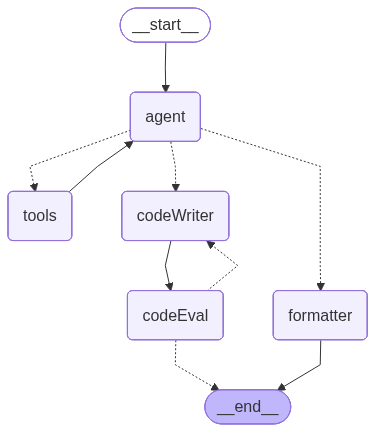

In [54]:
tool_node = ToolNode(tools)

# def tool_node(state: dict):
#     """Performs the tool call"""

#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}


workflow = StateGraph(ChatMessages)

## adding nodes
workflow.add_node('agent',call_agent)
workflow.add_node('tools',tool_node)
workflow.add_node('formatter',joblist_formatting)

## adding edges and routing
workflow.add_edge(START,'agent')
workflow.add_conditional_edges('agent',Are_tools_used) # setting router function for the agent
workflow.add_edge('tools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human
# workflow.add_edge('agent','formatter')

if 1<3:
    # Nodes
    workflow.add_node('codeWriter',code_writing)
    workflow.add_node('codeEval',code_eval)
    
    # edges
    # workflow.add_edge(START,'coderWriter')
    workflow.add_edge('codeWriter','codeEval')
    workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent
    # workflow.add_edge('tools','coder') # you want to link tools to agent because agent is responsible for giving an answer to human
    # workflow.add_edge('agent',END)

checkpointer = MemorySaver() # set memory
graph = workflow.compile(checkpointer=checkpointer ) # 
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [66]:
# %%time
# company2careerpage = {
#     'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
#     'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
#     'VISIUM':'https://www.visium.com/join-us#open-positions',
#     'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
#     'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
#     'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
#     'YPSOMED':'https://www.ypsomed.com/en/careers/jobs-at-ypsomed'
# }
# # 'Can you tell me who is the coolest guy in the universe?' #
# select     = 'AWS'
# question   = f'can you simply get the current jobs associated with this company {select}?'
# # question = 'can you tell me who is the coolest guy in the universe?'
# # question   = f"""can you write a short python code to list the jobs from the company {select} career page ({company2careerpage[select]})?""" 

# input_data = {"question": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
# res1       = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

In [ ]:
# print(res1['messages'][-1].content)

In [63]:
import os
import getpass

from langchain_anthropic import ChatAnthropic

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")



In [98]:
from langchain.tools import tool

# Augment the LLM with tools
tools = [get_AWS_jobs] # [add, multiply, divide] #
# llm_with_tools = ChatAnthropic(model="claude-sonnet-4-5").bind_tools(tools)
llm_with_tools = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)

In [99]:
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph.message import add_messages

class ChatMessages(TypedDict):
    
    messages: Annotated[Sequence[BaseMessage],add_messages]

# Nodes
def llm_call(state: ChatMessages):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with retrieving a job list"
                    )
                ]
                + state["messages"]
            )
        ]
    }

tool_node = ToolNode(tools)

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: ChatMessages) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

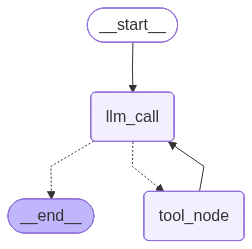

Senior Solutions Architect, Generative AI, Startups, AWS - https://www.amazon.jobs/jobs/3108132
Senior Solutions Architect - Healthcare & Life Sciences, Senior Solutions Architect HCLS - https://www.amazon.jobs/jobs/3107017
Senior Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059726
Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059723
Senior Delivery Consultant - Machine Learning (GenAI), ProServe EMEA, ProServe EMEA - https://www.amazon.jobs/jobs/3059727
Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059724

================================ Human Message =================================

Can you simply print the list of jobs retrieved
================================== Ai Message ==================================
Tool Calls:
  get_AWS_jobs (call_1jLRjzTYFfecF5axnrWBa13e)
 Call ID: call_1jLRjzTYFfecF5axnrWBa13e
  Args:
========================

In [100]:
# Build workflow
agent_builder = StateGraph(ChatMessages)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Can you simply print the list of jobs retrieved")]
# messages = [HumanMessage(content="what is 2 * 7")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()